In [107]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("XLSX")
Pkg.add("CSV")
Pkg.add("Distributions")


  Activating project at `~/Desktop/BEE 4750/BEE4750FinalProject-1`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`


In [108]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using XLSX
using CSV
using Distributions

Load Data for all buildings

In [109]:
# Read the CSV file into a DataFrame
df = CSV.read("CascadillaHall.csv", DataFrame)
date = df."Date"[1:366]
casc_steam = df."Steam (lbs/hr)"[1:366]
casc_electric = df."Electric (kW)"[1:366]
casc_data = Dict("steam" => casc_steam, "electric" => casc_electric)

df = CSV.read("HuShihHall.csv", DataFrame)
hushih_chilled_water = df."Chilled Water (tons)"[1:366]
hushih_hot_water = df."Hot Water (kBTU/hr)"[1:366]
hushih_electric = df."Electric (kW)"[1:366]
hushih_data = Dict("chilled water" => hushih_chilled_water, "hot water" => hushih_hot_water, "electric" => hushih_electric)

df = CSV.read("UrisLibrary.csv", DataFrame)
uris_chilled_water = df."Chilled Water (tons)"[1:366]
uris_electric = df."Electric (kW)"[1:366]
uris_steam = df."Steam (lbs/hr)"[1:366]
uris_data = Dict("steam" => uris_steam, "electric" => uris_electric, "chilled water" => uris_chilled_water)

df = CSV.read("MannLibrary.csv", DataFrame)
mann_chilled_water = df."Chilled Water (tons)"[1:366]
mann_electric = df."Electric (kW)"[1:366]
mann_steam = df."Steam (lbs/hr)"[1:366]
mann_data = Dict("steam" => mann_steam, "electric" => mann_electric, "chilled water" => mann_chilled_water)

df = CSV.read("BakerLab.csv", DataFrame)
baker_chilled_water = df."Chilled Water (tons)"[1:366]
baker_electric = df."Electric (kW)"[1:366]
baker_steam = df."Steam (lbs/hr)"[1:366]
baker_data = Dict("steam" => baker_steam, "electric" => baker_electric, "chilled water" => baker_chilled_water)


df = CSV.read("PSB.csv", DataFrame)
psb_chilled_water = df."Chilled Water (tons)"[1:366]
psb_electric = df."Electric (kW)"[1:366]
psb_steam = df."Steam (lbs/hr)"[1:366]
psb_data = Dict("steam" => psb_steam, "electric" => psb_electric, "chilled water" => psb_chilled_water)


Dict{String, Vector{Union{Missing, Float64}}} with 3 entries:
  "electric"      => [548.81, 563.161, 572.473, 565.196, 542.293, 544.875, 557.…
  "steam"         => [2079.73, 1909.23, 2041.34, 2451.04, 2452.6, 2104.94, 2016…
  "chilled water" => [64.7096, 66.233, 69.2405, 68.8494, 72.2633, 71.9422, 72.2…

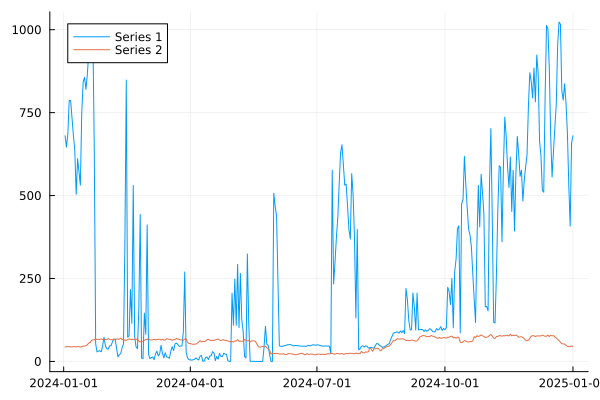

In [110]:
# Cascadilla plots
p = plot(date, casc_steam, label="Series 1")
plot!(p, date, casc_electric, label="Series 2")
display(p)

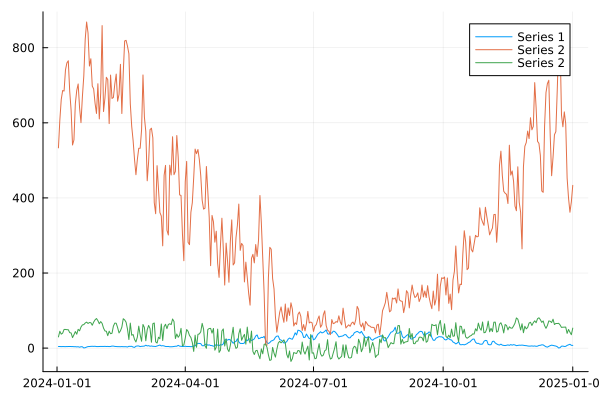

In [111]:
# Hu Shih Plots
p = plot(date, hushih_chilled_water, label="Series 1")
plot!(p, date, hushih_hot_water, label="Series 2")
plot!(p, date, hushih_electric, label="Series 2")
display(p)

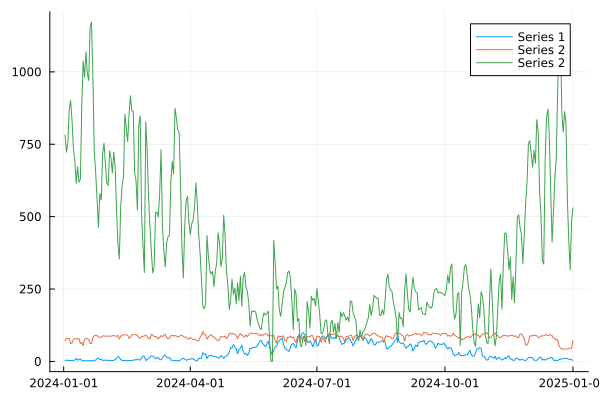

In [112]:
# Uris Library Plots
p = plot(date, uris_chilled_water, label="Series 1")
plot!(p, date, uris_electric, label="Series 2")
plot!(p, date, uris_steam, label="Series 2")
display(p)

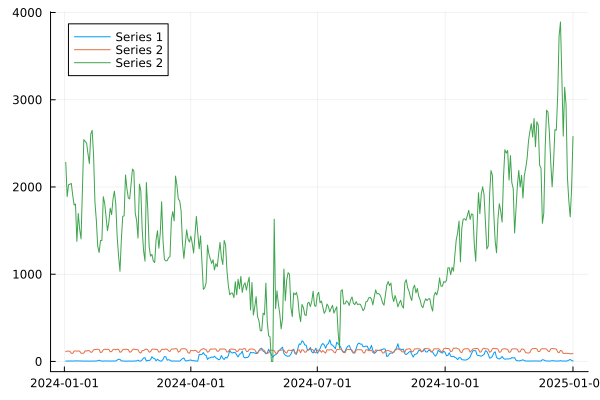

In [113]:
# Mann Library Plots
p = plot(date, mann_chilled_water, label="Series 1")
plot!(p, date, mann_electric, label="Series 2")
plot!(p, date, mann_steam, label="Series 2")
display(p)

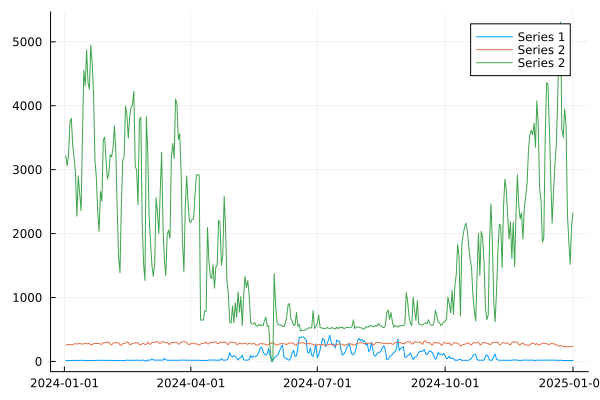

In [114]:
# Baker Lab Plots
p = plot(date, baker_chilled_water, label="Series 1")
plot!(p, date, baker_electric, label="Series 2")
plot!(p, date, baker_steam, label="Series 2")
display(p)

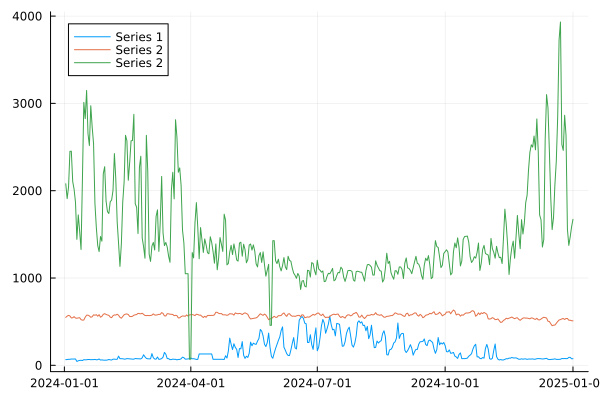

In [115]:
# PSB Plots
p = plot(date, psb_chilled_water, label="Series 1")
plot!(p, date, psb_electric, label="Series 2")
plot!(p, date, psb_steam, label="Series 2")
display(p)

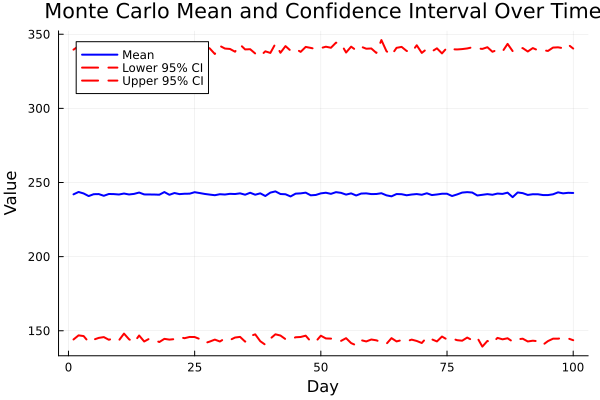

In [118]:
# Parameters of the true distribution
μ = 242.1
σ = 50
dist = Normal(μ, σ)

# Simulation parameters
days = 100                     # length of time series
N = 5000                       # samples per day
alpha = 0.05                   # 95% CI

# Storage
means = zeros(days)
lower_ci = zeros(days)
upper_ci = zeros(days)

for t in 1:days
    samples = rand(dist, N)

    means[t] = mean(samples)
    lower_ci[t] = quantile(samples, alpha/2)
    upper_ci[t] = quantile(samples, 1 - alpha/2)
end

# Plot
plot(1:days, means, label="Mean", lw=2, color=:blue)
plot!(1:days, lower_ci, label="Lower 95% CI", lw=2, ls=:dash, color=:red)
plot!(1:days, upper_ci, label="Upper 95% CI", lw=2, ls=:dash, color=:red)
xlabel!("Day")
ylabel!("Value")
title!("Monte Carlo Mean and Confidence Interval Over Time")


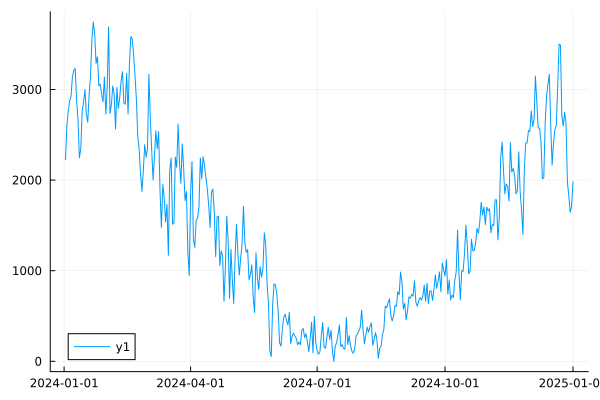

In [79]:
function calc_emissions(data_dict)
    emissions = zeros(366)
    for (key, values_vector) in data_dict
        if key == "steam"
            # Assumptions (based on CEP fast facts and 2020 report)
            # Plant efficiency: 76%
            # Energy losses in pipes: 27%
            # 795,000klbs = 819,000 mmBTU
            # 1 cubic foot of natural gas ≈ 1,037 Btu
            # 0.12 lbs CO2 / 1 cubic foot of natural gas
            for i in 1:366
                # convert lbs/hr to 819,000 mmBTU/hr
                mmBTU_hr = data_dict["steam"][i] * 819000/(795000*1000)
                # convert mmBTU at delivered to mmBTU of nat gas
                mmBTU_hr = mmBTU_hr / (1-0.27) / 0.76
                # convert mmBTU of nat gas to cubic ft natural gas
                cfs = mmBTU_hr * 1000000 / 1037
                # convert cubic ft natural gas to lbs CO2
                co2 = cfs * 0.12
                # hrs to day
                emissions[i] += co2*24
            end
        elseif key == "electric"
            # Source is egrid from the EPA
            for i in 1:366
                # convert kW reading into MWh for a day
                MWh = data_dict["electric"][i] * 24 / 1000
                # convert MWh to emissions (lbs CO2)
                emissions[i] += 242.1 * MWh
            end
            
        elseif key == "chilled water"
            # Assume lake source cooling, uses 0.1-0.15 kW/ton
            for i in 1:366
                # convert tons to kW
                kW = data_dict["chilled water"][i] * 0.125
                # convert kW reading into MWh for a day
                MWh = kW * 24 / 1000
                # convert MWh to emissions (lbs CO2)
                emissions[i] += 242.1 * MWh
            end
        elseif key == "hot water"
            # Changed assumption: energy losses in pipes: 5%
            for i in 1:366
                # convert kBTU/hr delivered to kBTU/hr of natural gas 
                kbtu_hr = data_dict["hot water"][i] / (1-0.05) / 0.76
                # convert kBTU of nat gas to cubic ft natural gas
                cfs = kbtu_hr * 1000 / 1037
                # convert cubic ft natural gas to lbs CO2
                co2 = cfs * 0.12
                # hrs to day
                emissions[i] += co2*24
            end
        else
            println("Unknown key found: $key")
        end
    end

    return emissions
end


e = calc_emissions(hushih_data)
plot(date, e)



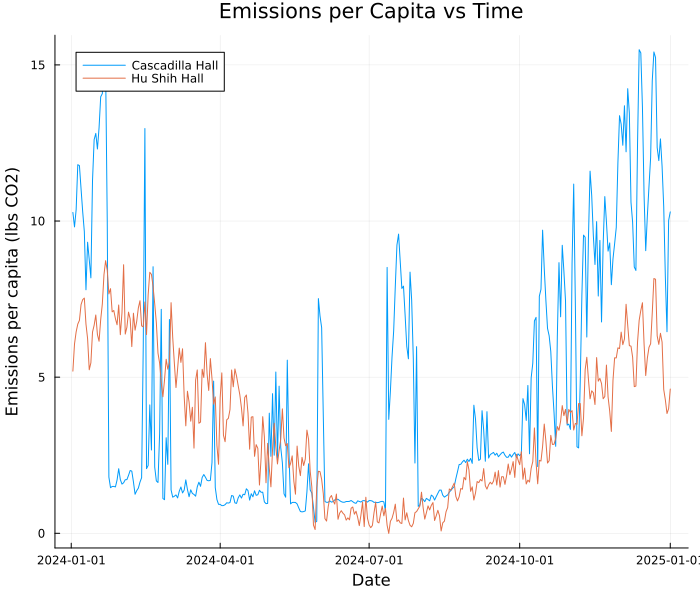

In [91]:
# PSB Plots
casc_emissions = calc_emissions(casc_data)
hushih_emissions = calc_emissions(hushih_data)

# adjust by number of residents
for i in 1:366
    casc_emissions[i] = casc_emissions[i] / 366
    hushih_emissions[i] = hushih_emissions[i] / 429
end

p = plot(date, casc_emissions, label="Cascadilla Hall", xlabel="Date", ylabel="Emissions per capita (lbs CO2)", title="Emissions per Capita vs Time", size=(700, 600))
plot!(p, date, hushih_emissions, label="Hu Shih Hall")
display(p)